In [1]:
import pandas as pd
import numpy as np
import re
from functools import reduce
import seaborn as sns
from matplotlib import pyplot as plt
from lower_case_dict import d_dict as D_dict
from lower_case_dict import D_ocupaciones
from lower_case_dict import d_describe as D_describe
from traduce import leyenda as tr_leyenda
pd.options.display.max_columns=None
pd.options.display.max_colwidth=310
pd.options.mode.chained_assignment=None

In [2]:
# Dataset completo procesado
ruta='data/formacion_procesado.csv'
df=pd.read_csv(ruta,index_col=0,low_memory=False)

# Naive decision tree

**Clasificador de ocupaciones a partir de títulos al estilo de un arbol de decisión**, con la diferencia de que, en lugar de identificar el punto de corte más explicativo en cada etapa, este clasificador solo reparte en ramas una vez y crea **tantas ramas como títulos distintos** haya en el dataset.   

Para cada título identifica todas las ocupaciones, las ordena de más a menos frecuentes y  selecciona como predicción las ocupaciones en el **top n del ranking de frecuencias** que, además, estén por encima de un **umbral de frecuencia relativa establecido como mínimo**.   

Para cada título, este clasificador devuelve como **predicción una lista de ocupaciones ordenadas** de más a menos probables.   

Los **parámetros de este modelo** son el número n de posiciones en el ranking que se seleccionan como predictores y el umbral de frecuencia mínima.   

El número de ocupaciones en la predicción para cada título puede ser mayor o menor que  n, el número de posiciones en el ranking de frecuencias que se tienen en cuenta:   

- Si alguna ocupación en el top n del ranking tiene una frecuencia inferior al umbral, se descarta como predictor. Así, es posible que la lista de ocupaciones seleccionadas tenga menos de n elementos.  

- Cuando hay empates entre ocupaciones en el top n de frecuencias, se incluyen en la predicción todas las que pertenecen al grupo empatado. Esto hace posible que se seleccionen más de n ocupaciones como predicción. 

El algoritmo se ha construido sobre las columnas de título y de ocupacion literales en lugar de las nuḿericas. Se ha decidido así porque facilita el hacerse una idea de cuáles son las titulaciones para las que es más o menos probable hacer predicciones acertadas durante el proceso de construcción del clasificador. 

## Objetivo

El objetivo de la construcción de un clasificador elemental es conocer en qué medida las titulaciones universitarias explican por sí solas las profesiones que alcanzan los titulados.   
Se espera un éxito modesto por varios motivos:   

- Los títulos universitarios no son el único critero de los empleadores para seleccionar a su plantilla. Por un lado, un título universitario suele ser insuficiente por sí solo para aspirar a un buen número de puestos de trabajo reservados a universitarios. Por otro lado, a menudo los candidatos a un empleo pueden suplir la falta de un título universitario especializado a menudo con otros méritos, como la experiencia profesional o la formación en disciplinas afines. Los estudios de medicina son una excepción clara a esta posibilidad; los resultados constatan que las profesiones sanitarias están reservadas a titulados con formación especializada (aunque no todos los que tienen esa formación trabajan en ocupaciones relacionadas con su título). 

- Las encuestas empleadas en este proyecto solo informan con detalle de un título universitario de cada encuestado. Aquellos que han accedido a su profesión gracias a un título distinto del que les hace elegibles para la encuesta en la que participan (otro grado, otro máster, un título de doctor) se escapan a la capacidad predictiva de los modelos basados en estos datos.  Esto se notará especialmente en los casos en los que el encuestado responde sobre un título que ha estudiado por motivos distintos a búsqueda de empleo o la promoción profesional mientras trabajaban en ocupaciones a las que accedieron gracias a una titulación previa.  

- El mal funcionamiento del mercado de trabajo español empuja a muchos aspirantes a un empleo a aceptar trabajos poco o nada relacionados con su formación y sus conocimientos.   


## Justificación
**Ventajas de la construcción del algoritmo a medida** (en lugar de emplear una solución estándar):  
- **Simplicidad** de la justificación teórica que sustenta las predicciones. Facilita la interpretación de los resultados.  

- Clasificador **específico** para el caso en el que **el regresor y el target son variables categóricas**.  
  
- El proceso de construcción del algoritmo es, en su mayor parte, un **análisis descriptivo** de las relaciones entre titulaciones y ocupaciones. Este análisis se ha ilustrado y probado con los datos de la encuesta completa para estimar la dificultad del problema de clasificación (que se resuelve, más adelante, sobre subconjuntos de train, validación y test).  
  
- **Flexibilidad** para definir los criterios de agregación de las métricas de evaluación, por titulaciones o por ocupaciones. Facilita la identificación de los títulos y las profesiones para las que es más y menos probable hacer predicciones acertadas. 

# Dataset encuesta y dataset filtrado por 'utilidad'

#### Observaciones con target informado

In [3]:
# Selección: solo ocupaciones informadas
df=df[df['ocupacion'].notna()]
df.shape

(59844, 311)

#### Número de categorías distintas del target: 

In [4]:
df['ocupacion'].nunique()
# Ocupaciones distintas (núm. categorías del target):

62

#### Número de categorías distintas del regresor: 

In [5]:
df['titulo_ppal_'].nunique()
# Titulos distintos (num. categorías del regresor principal): 

173

### Filtro  por utilidad: 
Solo encuestados que declaran que el título les ha sido útil para encontrar trabajo.   
Se pierden unas 30000 observaciones. El dataset reducido conserva todas las ocupaciones y todos los titulos presentes en la encuesta. 

In [6]:
dfr=df[df['utilidad']==1]
dfr.shape[0]

41283

In [7]:
dfr['ocupacion'].nunique()

62

In [8]:
dfr['titulo_ppal_'].nunique()

173

# Número de ocupaciones distintas por título

### Regresor y target:
En adelante se identifican el título principal como regresor y la ocupación como target. Esto facilitará la generalización del clasificador naive a otros targets y regresores. 

In [9]:
def num_cat_targets_por_cat_regresor(data,regresor,target):
    columnas=[regresor,target]
    out=data[columnas].groupby(regresor).agg(['nunique'])
    out.columns=out.columns.to_flat_index() 
    out.rename(columns={out.columns[-1]:'num categorias target por regresor'},inplace=True)
    out.sort_values(by='num categorias target por regresor',inplace=True)
    out.reset_index(inplace=True)
    
    return out

In [10]:
num_oc_por_titulo_encuesta=num_cat_targets_por_cat_regresor(data=df,regresor='titulo_ppal_',target='ocupacion_')
num_oc_por_titulo_encuesta

,titulo_ppal_,num categorias target por regresor
0,Grado Odontología,5
1,Máster Odontología,6
2,"Máster Ciencias químicas, físicas y geológicas; Matemáticas y estadística (Otros estudios)",8
3,Máster Religión y teología,9
4,Máster Lenguas (Otros estudios),10
...,...,...
168,Grado Educación primaria,52
169,Grado Economía,53
170,Grado Historia,53
171,Grado Arquitectura técnica,53


###### (*) La distribución del número de ocupaciones por título es igual en el dataset original y en el reducido con el filtro de 'utilidad':

In [11]:
num_oc_por_titulo_filtro=num_cat_targets_por_cat_regresor(dfr,regresor='titulo_ppal_',target='ocupacion_')
#num_oc_por_titulo_filtro

In [12]:
oc_por_titulo=pd.DataFrame({'encuesta':num_oc_por_titulo_encuesta['num categorias target por regresor'],
                     'filtro':num_oc_por_titulo_filtro['num categorias target por regresor']})
oc_por_titulo['encuesta'].equals(oc_por_titulo['filtro'])

False

[Text(0.5, 1.0, 'Distribución del número de ocupaciones por título'),
 Text(0.5, 0, 'Número de ocupaciones por título')]

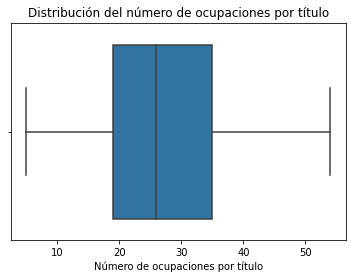

In [13]:
ax=sns.boxplot(data=num_oc_por_titulo_encuesta,x='num categorias target por regresor')
ax.set(title='Distribución del número de ocupaciones por título',xlabel='Número de ocupaciones por título')

Text(0, 0.5, 'Frecuencia')

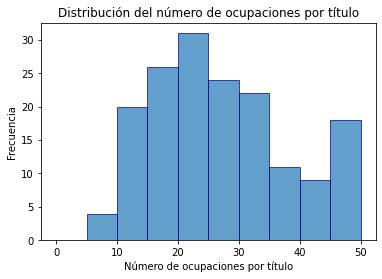

In [14]:
plt.hist(num_oc_por_titulo_encuesta['num categorias target por regresor'],bins=np.arange(0,55,5),\
         color='tab:blue',alpha=0.7,edgecolor='darkblue',linewidth=1)
plt.title('Distribución del número de ocupaciones por título')
plt.xlabel('Número de ocupaciones por título')
plt.ylabel('Frecuencia')

## Número de ocupaciones distintas por título: resumen 

In [15]:
num_oc_por_titulo_encuesta['num categorias target por regresor'].describe()

count    173.000000
mean      27.705202
std       12.290563
min        5.000000
25%       19.000000
50%       26.000000
75%       35.000000
max       54.000000
Name: num categorias target por regresor, dtype: float64

# Número de ocupaciones distintas por rama de conocimento

In [16]:
# df auxiliar para añadir ramas de conocimiento a la distribución de número de ocupaciones por título
df_ramas=df[['titulo_ppal_','rama_ppal_']].drop_duplicates()
df_ramas

,titulo_ppal_,rama_ppal_
0,Grado Pedagogía,Ciencias sociales y jurídicas
398,Grado Pedagogía,Artes y humanidades
568,Grado Educación infantil,Ciencias sociales y jurídicas
1933,Grado Educación primaria,Ciencias sociales y jurídicas
3840,Grado Otros maestros,Ciencias sociales y jurídicas
...,...,...
42421,Máster Electrónica y automática,Ciencias sociales y jurídicas
42565,Máster Economía,Artes y humanidades
73356,Grado Servicios (otros estudios),Artes y humanidades
73358,Grado Servicios (otros estudios),Ciencias de la salud


In [17]:
num_oc_por_titulo_ramas=num_oc_por_titulo_encuesta.merge(df_ramas,on='titulo_ppal_',how='left')
num_oc_por_titulo_ramas

,titulo_ppal_,num categorias target por regresor,rama_ppal_
0,Grado Odontología,5,Ciencias de la salud
1,Máster Odontología,6,Ciencias de la salud
2,"Máster Ciencias químicas, físicas y geológicas; Matemáticas y estadística (Otros estudios)",8,Ciencias
3,Máster Religión y teología,9,Artes y humanidades
4,Máster Lenguas (Otros estudios),10,Artes y humanidades
...,...,...,...
273,Grado Educación primaria,52,Ciencias sociales y jurídicas
274,Grado Economía,53,Ciencias sociales y jurídicas
275,Grado Historia,53,Artes y humanidades
276,Grado Arquitectura técnica,53,Ingeniería y arquitectura


[Text(0, 0, 'Ciencias de la salud'),
 Text(1, 0, 'Ciencias'),
 Text(2, 0, 'Artes y humanidades'),
 Text(3, 0, 'Ingeniería y arquitectura'),
 Text(4, 0, 'Ciencias sociales y jurídicas')]

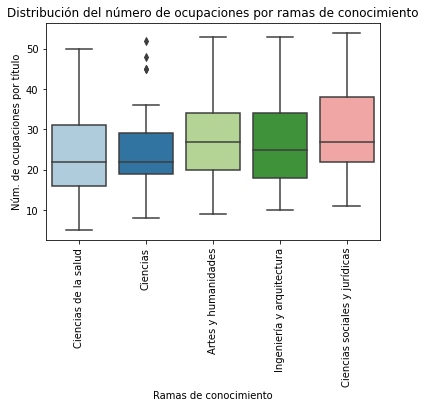

In [18]:
ax = sns.boxplot(data=num_oc_por_titulo_ramas, x='rama_ppal_',\
                 y='num categorias target por regresor', palette='Paired')
ax.set(title='Distribución del número de ocupaciones por ramas de conocimiento',xlabel='Ramas de conocimiento',
       ylabel='Núm. de ocupaciones por título')
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)

In [19]:
df['ambito_g1_'].unique()

array(['Educación (Otros estudios) ',
       'Formación de docentes de enseñanza infantil ',
       'Formación de docentes de enseñanza primaria ',
       'Técnicas audiovisuales y medios de comunicación ',
       'Artes (Otros estudios) ', 'Humanidades ', 'Lenguas ', 'Economía ',
       'Ciencias sociales y del comportamiento (Otros estudios) ',
       'Psicología ', 'Periodismo y documentación ',
       'Negocios y administración (Otros estudios) ',
       'Dirección y administración ', 'Derecho ', 'Ciencias de la vida ',
       'Medio ambiente ', 'Ciencias químicas, físicas y geológicas ',
       'Matemáticas y estadística ', 'Informática',
       'Ingeniería y profesiones afines ',
       'Industria manufacturera y producción ',
       'Arquitectura y construcción ', 'Agricultura y ganadería ',
       'Silvicultura ', 'Veterinaria ', 'Salud (Otros estudios) ',
       'Medicina ', 'Enfermería ', 'Servicios sociales ',
       'Actividades físicas y deportivas ', 'Viajes, turismo y oc

In [20]:
df['ambito_m1_'].unique()

array([nan, 'SALUD Y SERVICIOS SOCIALES', 'EDUCACIÓN', 'INFORMÁTICA',
       'CIENCIAS', 'INGENIERÍA, INDUSTRIA Y CONSTRUCCIÓN',
       'NEGOCIOS, ADMINISTRACIÓN Y DERECHO', 'SERVICIOS',
       'CIENCIAS SOCIALES, PERIODISMO Y DOCUMENTACIÓN',
       'ARTES Y HUMANIDADES',
       'AGRICULTURA, GANADERÍA, SILVICULTURA, PESCA Y VETERINARIA'],
      dtype=object)

## Número de titulados por título: 

In [21]:
def num_obs_por_cat_regresor(data,regresor,target):
    
    columnas=[regresor,target]
    out=data[columnas].groupby([regresor]).agg(['count'])
    out.columns=out.columns.to_flat_index()
    out.reset_index(inplace=True)
    out.rename(columns={out.columns[-1]:'obs regresor'},inplace=True)
    
    previo=num_cat_targets_por_cat_regresor(data=data,regresor=regresor,target=target)
    out=out.merge(previo,on=regresor,how='outer')
    out=out.sort_values(by='num categorias target por regresor')
    out.reset_index(drop=True,inplace=True)
    
    return out

In [22]:
num_titulados_encuesta=num_obs_por_cat_regresor(data=df,regresor='titulo_ppal_',target='ocupacion_')
num_titulados_encuesta

,titulo_ppal_,obs regresor,num categorias target por regresor
0,Grado Odontología,243,5
1,Máster Odontología,73,6
2,"Máster Ciencias químicas, físicas y geológicas; Matemáticas y estadística (Otros estudios)",31,8
3,Máster Religión y teología,25,9
4,Máster Lenguas (Otros estudios),53,10
...,...,...,...
168,Grado Educación primaria,2065,52
169,Grado Economía,1174,53
170,Grado Historia,697,53
171,Grado Arquitectura técnica,1050,53


## Número de profesionales por título y ocupación: 

In [23]:
def num_cat_target_por_regresor_y_target(data,regresor,target):
    
    columnas=[regresor,target]
    out=data[columnas].groupby(regresor).agg(['value_counts'])
    out.columns=out.columns.to_flat_index()
    out.reset_index(inplace=True)
    out.rename(columns={out.columns[-1]:'obs target'},inplace=True)
    
    previo=num_obs_por_cat_regresor(data=data,regresor=regresor,target=target)
    out=previo.merge(out,on=regresor,how='outer')
    out.sort_values(by=['num categorias target por regresor','obs target'],ascending=[True,False],inplace=True)
    
    return out

In [24]:
prof_por_oc_y_titulo_encuesta=num_cat_target_por_regresor_y_target(data=df,
                                                                   regresor='titulo_ppal_',target='ocupacion_')
prof_por_oc_y_titulo_encuesta

,titulo_ppal_,obs regresor,num categorias target por regresor,ocupacion_,obs target
0,Grado Odontología,243,5,Prof sanitarios,237
1,Grado Odontología,243,5,Gerentes em servicios excepto hostelería y comercio,2
2,Grado Odontología,243,5,Prof enseñanza,2
3,Grado Odontología,243,5,Directores producción y operaciones,1
4,Grado Odontología,243,5,Trabajadores servicios de cuidados de salud,1
...,...,...,...,...,...
4788,Grado Administración y empresa,2637,54,Montadores y ensambladores en fábricas,1
4789,Grado Administración y empresa,2637,54,Peones de construcción y minería,1
4790,Grado Administración y empresa,2637,54,Trabajadores construcción e instalaciones: acabado,1
4791,Grado Administración y empresa,2637,54,Trabajadores construcción y afines: estructura,1


## Proporción de profesionales sobre titulados por ocupación y título
Frecuencias relativas y frecuencias relativas acumuadas de las ocupaciones para cada título.   
(*) Para calcular las frecuencias acumuladas se ordenan las ocupaciones por frecuencia relativa en orden descendente. 

In [25]:
def frecuencias_cat_target_por_regresor(data,regresor,target):
    
    previo=num_cat_target_por_regresor_y_target(data=data,regresor=regresor,target=target)
    # 'prop' = proporción de obs. del target sobre núm. obs. para la categoría del regresor: 
    previo['prop']=previo['obs target'].div(previo['obs regresor'])
    
    # Frecuencias acumuladas: 
    acum=previo[[regresor,'prop']].groupby(regresor).cumsum()
    acum.rename(columns={acum.columns[-1]:'prop acum'},inplace=True)
    
    out=previo.merge(acum,left_index=True,right_index=True,how='outer')
    
    
    return out

In [26]:
proporciones_encuesta=frecuencias_cat_target_por_regresor(data=df,regresor='titulo_ppal_',target='ocupacion_')
proporciones_encuesta

,titulo_ppal_,obs regresor,num categorias target por regresor,ocupacion_,obs target,prop,prop acum
0,Grado Odontología,243,5,Prof sanitarios,237,0.975309,0.975309
1,Grado Odontología,243,5,Gerentes em servicios excepto hostelería y comercio,2,0.008230,0.983539
2,Grado Odontología,243,5,Prof enseñanza,2,0.008230,0.991770
3,Grado Odontología,243,5,Directores producción y operaciones,1,0.004115,0.995885
4,Grado Odontología,243,5,Trabajadores servicios de cuidados de salud,1,0.004115,1.000000
...,...,...,...,...,...,...,...
4788,Grado Administración y empresa,2637,54,Montadores y ensambladores en fábricas,1,0.000379,0.998483
4789,Grado Administración y empresa,2637,54,Peones de construcción y minería,1,0.000379,0.998862
4790,Grado Administración y empresa,2637,54,Trabajadores construcción e instalaciones: acabado,1,0.000379,0.999242
4791,Grado Administración y empresa,2637,54,Trabajadores construcción y afines: estructura,1,0.000379,0.999621


## Ranking de ocupaciones por título: 

In [27]:
def ranking_cat_target_por_cat_regresor(data,regresor,target):
    
    previo=frecuencias_cat_target_por_regresor(data=data,regresor=regresor,target=target)
    rank=previo[[regresor,'obs target']]
    rank=rank.groupby(regresor).rank(method='min',ascending=False)
    rank.rename(columns={rank.columns[-1]:'rank'},inplace=True)
    
    out=previo.merge(rank,how='outer',left_index=True,right_index=True)
    out.sort_values(by=['num categorias target por regresor','rank'],inplace=True)
    
    return out 

In [28]:
ranking_encuesta=ranking_cat_target_por_cat_regresor(data=df,regresor='titulo_ppal_',target='ocupacion_')
ranking_encuesta

,titulo_ppal_,obs regresor,num categorias target por regresor,ocupacion_,obs target,prop,prop acum,rank
0,Grado Odontología,243,5,Prof sanitarios,237,0.975309,0.975309,1.0
1,Grado Odontología,243,5,Gerentes em servicios excepto hostelería y comercio,2,0.008230,0.983539,2.0
2,Grado Odontología,243,5,Prof enseñanza,2,0.008230,0.991770,2.0
3,Grado Odontología,243,5,Directores producción y operaciones,1,0.004115,0.995885,4.0
4,Grado Odontología,243,5,Trabajadores servicios de cuidados de salud,1,0.004115,1.000000,4.0
...,...,...,...,...,...,...,...,...
4788,Grado Administración y empresa,2637,54,Montadores y ensambladores en fábricas,1,0.000379,0.998483,48.0
4789,Grado Administración y empresa,2637,54,Peones de construcción y minería,1,0.000379,0.998862,48.0
4790,Grado Administración y empresa,2637,54,Trabajadores construcción e instalaciones: acabado,1,0.000379,0.999242,48.0
4791,Grado Administración y empresa,2637,54,Trabajadores construcción y afines: estructura,1,0.000379,0.999621,48.0


# Ranking de ocupaciones más frecuentes por título (clasificador naive) 

Equivalente al proceso de entrenamiento.

In [29]:
def naive_fit(data,regresor,target,max_rank,min_prop):
    
    previo=ranking_cat_target_por_cat_regresor(data=data,regresor=regresor,target=target)
    
    naive=previo[previo['rank']<=max_rank]
    naive=naive[naive['prop']>=min_prop]
    
    naive.sort_values(by=['num categorias target por regresor',regresor,'rank'],inplace=True)
    naive.reset_index(drop=True,inplace=True)
    naive.rename(columns={regresor:'regresor: '+regresor, target:'target: '+target},inplace=True)
    
    return naive

In [30]:
naive_encuesta=naive_fit(data=df,regresor='titulo_ppal_',target='ocupacion_',max_rank=5,min_prop=0.05)
naive_encuesta.sample(2)

,regresor: titulo_ppal_,obs regresor,num categorias target por regresor,target: ocupacion_,obs target,prop,prop acum,rank
285,Máster Terapia y rehabilitación,153,22,Prof enseñanza,23,0.150327,0.712418,2.0
554,Grado Pedagogía,816,44,Prof ciencias sociales,49,0.060049,0.667892,3.0


In [31]:
with pd.option_context("display.max_rows", naive_encuesta.shape[0]):
    display(naive_encuesta)

,regresor: titulo_ppal_,obs regresor,num categorias target por regresor,target: ocupacion_,obs target,prop,prop acum,rank
0,Grado Odontología,243,5,Prof sanitarios,237,0.975309,0.975309,1.0
1,Máster Odontología,73,6,Prof sanitarios,66,0.904110,0.904110,1.0
2,"Máster Ciencias químicas, físicas y geológicas; Matemáticas y estadística (Otros estudios)",31,8,Prof enseñanza,12,0.387097,0.387097,1.0
3,"Máster Ciencias químicas, físicas y geológicas; Matemáticas y estadística (Otros estudios)",31,8,"Prof ciencias, matemáticas e ingeniería",5,0.161290,0.548387,2.0
4,"Máster Ciencias químicas, físicas y geológicas; Matemáticas y estadística (Otros estudios)",31,8,Profesionales IT,4,0.129032,0.677419,3.0
5,"Máster Ciencias químicas, físicas y geológicas; Matemáticas y estadística (Otros estudios)",31,8,Técnicos ciencias e ingenierías,4,0.129032,0.806452,3.0
6,"Máster Ciencias químicas, físicas y geológicas; Matemáticas y estadística (Otros estudios)",31,8,Técnicos TI,3,0.096774,0.903226,5.0
7,Máster Religión y teología,25,9,Prof enseñanza,13,0.520000,0.520000,1.0
8,Máster Religión y teología,25,9,Prof ciencias sociales,5,0.200000,0.720000,2.0
9,Grado Medicina,1433,10,Prof sanitarios,1410,0.983950,0.983950,1.0


# Entrenamiento, validación y test
Se separan los dataset de train, validación y test sin distinguir regresores y target porque es más conveniente mantener todas las columnas en un dataframe único para aplicar el algoritmo y evaluar los resultados. 

In [32]:
def train_vld_test(df):
    df.sample(frac=1,random_state=23) # reordenación aleatoria
    n_train=int(df.shape[0]*0.6)
    n_vld=int(df.shape[0]*0.8)
    df_train=df[:n_train]
    df_vld=df[n_train:n_vld]
    df_test=df[n_vld:]
    
    return df_train, df_vld, df_test

#### Dataset original: 

In [33]:
df_train, df_vld, df_test =train_vld_test(df)
df_train.shape[0]+df_vld.shape[0]+df_test.shape[0]==df.shape[0] # Comprobación

True

#### Dataset reducido (filtro 'utilidad'): 

In [34]:
dfr_train, dfr_vld, dfr_test =train_vld_test(dfr)

# Predicciones 

In [35]:
def naive_prediccion(clasificador,valor_regresor):
    
    import re
    regresor=list(filter(lambda col: col.startswith('regresor:'),naive_train_5_05.columns))[0]
    target=list(filter(lambda col: col.startswith('target:'),naive_train_5_05.columns))[0]
    
    modelo=clasificador[clasificador[regresor]==valor_regresor]
    prd=modelo[[target,'prop']]
    prd.reset_index(drop=True,inplace=True)
    prd.rename(columns={target:'prediccion','prop':'probabilidad'},inplace=True)
    
    return prd

In [36]:
# Fit en train:
naive_train_5_05=naive_fit(data=df_train,regresor='titulo_ppal_',target='ocupacion_',max_rank=5,min_prop=0.05)
naive_train_5_05  

,regresor: titulo_ppal_,obs regresor,num categorias target por regresor,target: ocupacion_,obs target,prop,prop acum,rank
0,Grado Odontología,125,4,Prof sanitarios,120,0.960000,0.960000,1.0
1,Máster Odontología,60,5,Prof sanitarios,54,0.900000,0.900000,1.0
2,Máster Odontología,60,5,Prof enseñanza,3,0.050000,0.950000,2.0
3,"Máster Ciencias químicas, físicas y geológicas; Matemáticas y estadística (Otros estudios)",29,8,Prof enseñanza,12,0.413793,0.413793,1.0
4,"Máster Ciencias químicas, físicas y geológicas; Matemáticas y estadística (Otros estudios)",29,8,"Prof ciencias, matemáticas e ingeniería",4,0.137931,0.551724,2.0
...,...,...,...,...,...,...,...,...
693,Grado Administración y empresa,1757,52,"Expertos en gestión, finanzas, comercio, etc",344,0.195788,0.195788,1.0
694,Grado Administración y empresa,1757,52,"Empleados servicios financieros, contables y de apoyo",246,0.140011,0.335800,2.0
695,Grado Administración y empresa,1757,52,Empleados administrativos sin atención al público,218,0.124075,0.459875,3.0
696,Grado Administración y empresa,1757,52,Representantes e intermediarios,113,0.064314,0.524189,4.0


In [37]:
# Inspección: 
naive_prediccion(naive_train_5_05,valor_regresor='Máster Odontología')

,prediccion,probabilidad
0,Prof sanitarios,0.90
1,Prof enseñanza,0.05


In [38]:
# Inspección: 
naive_prediccion(naive_train_5_05,valor_regresor='Grado Economía')

,prediccion,probabilidad
0,"Expertos en gestión, finanzas, comercio, etc",0.182504
1,"Empleados servicios financieros, contables y de apoyo",0.138763
2,Empleados administrativos sin atención al público,0.096531
3,Otros empleados administrativos con atención al público,0.067873
4,Representantes e intermediarios,0.063348


In [39]:
# Inspección: 
naive_prediccion(naive_train_5_05,valor_regresor='Grado Matemáticas')

,prediccion,probabilidad
0,Prof enseñanza,0.394040
1,Profesionales IT,0.145695
2,"Prof ciencias, matemáticas e ingeniería",0.119205
3,Técnicos TI,0.096026
4,"Expertos en gestión, finanzas, comercio, etc",0.072848


In [40]:
sdfghjk

NameError: name 'sdfghjk' is not defined

# Evaluación del clasificador

In [ ]:
def evalua_top_n(data):
    
    evalua=data[['titulo_ppal_','ocupacion_']]
    evalua['prediccion']=evalua['titulo_ppal_'].apply(lambda x: prediccion_top_n(x)['prediccion'].tolist())
    
    evalua['acierto']=evalua.apply(lambda x: x['ocupacion_'] in x['prediccion'],axis=1).astype(int)
    
    aux_aciertos_titulo=evalua[['titulo_ppal_','acierto']].groupby('titulo_ppal_').agg(['sum'])
    aux_aciertos_titulo.columns=aux_aciertos_titulo.columns.to_flat_index()
    evalua=evalua.merge(aux_aciertos_titulo,on='titulo_ppal_',how='outer')
    evalua.rename(columns={evalua.columns[-1]:'aciertos titulo'},inplace=True)
    
    aux_total_titulados=evalua[['titulo_ppal_','acierto']].groupby('titulo_ppal_').agg(['count'])
    aux_total_titulados.columns=aux_total_titulados.columns.to_flat_index()
    evalua=evalua.merge(aux_total_titulados,on='titulo_ppal_',how='outer')
    evalua.rename(columns={evalua.columns[-1]:'num titulados'},inplace=True)
    
    evalua['accuracy titulo']=evalua['aciertos titulo'].div(evalua['num titulados'])
    
    total_obs=evalua.shape[0]
    
    evalua['peso titulo']=evalua['num titulados']/total_obs
    evalua['accuracy ponderado titulo']=evalua['accuracy titulo']*evalua['peso titulo']
    
    aux_aciertos_ocupacion=evalua[['ocupacion_','acierto']].groupby('ocupacion_').agg(['sum'])
    aux_aciertos_ocupacion.columns=aux_aciertos_ocupacion.columns.to_flat_index()
    evalua=evalua.merge(aux_aciertos_ocupacion,on='ocupacion_',how='outer')
    evalua.rename(columns={evalua.columns[-1]:'aciertos ocupacion'},inplace=True)
    
    aux_total_profesionales=evalua[['ocupacion_','acierto']].groupby('ocupacion_').agg(['count'])
    aux_total_profesionales.columns=aux_total_profesionales.columns.to_flat_index()
    evalua=evalua.merge(aux_total_profesionales,on='ocupacion_',how='outer')
    evalua.rename(columns={evalua.columns[-1]:'num profesionales'},inplace=True)
  
    evalua['accuracy ocupacion']=evalua['aciertos ocupacion'].div(evalua['num profesionales'])

    evalua['peso ocupacion']=evalua['num profesionales']/total_obs
    evalua['accuracy ponderado ocupacion']=evalua['accuracy ocupacion']*evalua['peso ocupacion']
    

    return evalua

### Evaluación desagregada (en train):

In [ ]:
df_train_evalua_top_n=evalua_top_n(df_train)
df_train_evalua_top_n.sample(2)

In [ ]:
df_train_evalua_top_n['acierto'].sum()/df_train_evalua_top_n['acierto'].count()

### Evaluación desagregada (en validación):

In [ ]:
df_vld_evalua_top_n=evalua_top_n(df_vld)
df_vld_evalua_top_n.sample(2)

In [ ]:
df_vld_evalua_top_n['acierto'].sum()/df_vld_evalua_top_n['acierto'].count()

### Métricas de evaluación por títulos y por ocupaciones: 

In [ ]:
def evalua_top_n_regresor(data):
    evalua=evalua_top_n(data)
    lista_re_regresor=['titulo_ppal_','aciertos titulo','num titulados','accuracy titulo','peso titulo',\
                       'accuracy ponderado titulo']
    evalua_regresor=evalua[lista_re_regresor].drop_duplicates()
    evalua_regresor.set_index('titulo_ppal_',inplace=True)

    return evalua_regresor

In [ ]:
df_vld_evalua_top_n_regresor=evalua_top_n_regresor(df_vld)
df_vld_evalua_top_n_regresor

In [ ]:
sns.boxplot(df_vld_evalua_top_n_regresor['accuracy titulo'])

In [ ]:
def evalua_top_n_target(data):
    evalua=evalua_top_n(data)
    lista_re_target=['ocupacion_','aciertos ocupacion','num profesionales','accuracy ocupacion','peso ocupacion',
                     'accuracy ponderado ocupacion']
    evalua_target=evalua[lista_re_target].drop_duplicates()
    evalua_target.set_index('ocupacion_',inplace=True)

    return evalua_target

In [ ]:
df_vld_evalua_top_n_target=evalua_top_n_target(df_vld)
df_vld_evalua_top_n_target

In [ ]:
sns.boxplot(df_vld_evalua_top_n_target['accuracy ocupacion'])

## Resúmenes de métricas de evaluación por titulaciones y por ocupaciones

In [ ]:
def evalua_top_n_regresor_resumen(data):
    evalua_regresor=evalua_top_n_regresor(data)
    evalua_resumen=evalua_regresor.agg(['sum','mean','median','min','argmin','max','argmax'])
    # Ajustes argmin y argmax: 
    for col in evalua_resumen.columns: 
        for arg in ['argmin','argmax']:
            indice_titulo=int(evalua_resumen.loc[arg,col])
            evalua_resumen.loc[arg,col]=evalua_regresor.index[indice_titulo]
    # Ajustes 'no aplica' (sumas o índices que no tienen sentido):
    evalua_resumen.loc['sum','accuracy titulo']=''

    return evalua_resumen

In [ ]:
resumen_regresor_validacion= evalua_top_n_regresor_resumen(df_vld)
resumen_regresor_validacion

In [ ]:
def evalua_top_n_target_resumen(data):
    evalua_target=evalua_top_n_target(data)
    evalua_resumen=evalua_target.agg(['sum','mean','median','min','argmin','max','argmax'])
    # Ajustes argmin y argmax: 
    for col in evalua_resumen.columns: 
        for arg in ['argmin','argmax']:
            indice_ocupacion=int(evalua_resumen.loc[arg,col])
            evalua_resumen.loc[arg,col]=evalua_target.index[indice_ocupacion]
    # Ajustes 'no aplica' (sumas o índices que no tienen sentido):
    evalua_resumen.loc['sum','accuracy ocupacion']=''

    return evalua_resumen

In [ ]:
resumen_target_validacion=evalua_top_n_target_resumen(df_vld)
resumen_target_validacion